## Petrophysical properties inversion from seismic data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5442599339039860690
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4886273255419661116
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12651169942176056735
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2643665252134120971
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('../../../Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('../../../Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('../../../Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('../../../Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('../../../Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'RHOB')

<Figure size 720x720 with 0 Axes>

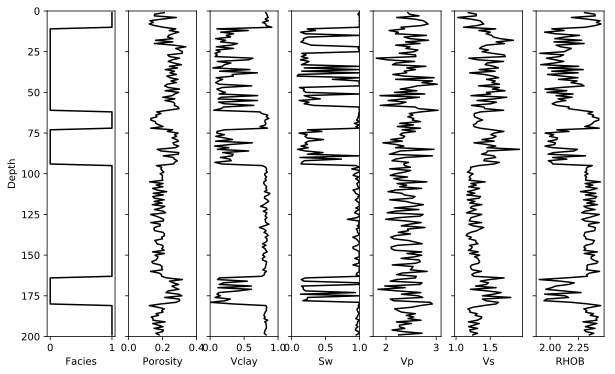

In [4]:
# Plot of loaded data

plt.figure(figsize=(10,10))

sample_number = 12
f, axarr = plt.subplots(1, 7, sharey = True, figsize=(10,6))

axarr[0].plot(facies[sample_number, :], depth, color = "black")
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")
axarr[0].set_ylim([0,200])
axarr[0].invert_yaxis()

axarr[1].plot(porosity[sample_number, :], depth, color = "black")
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth, color = "black")
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth, color = "black")
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :], depth, color = "black")
axarr[4].set_xlabel("Vp")
# plt.xlim(0,1)

axarr[5].plot(Vs[sample_number, :], depth, color = "black")
axarr[5].set_xlabel("Vs")
# plt.xlim(0,1)

axarr[6].plot(RHOB[sample_number, :], depth, color = "black")
axarr[6].set_xlabel("RHOB")
# plt.xlim(0,1)

# axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
# axarr[7].set_xlabel("Ip")

In [5]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


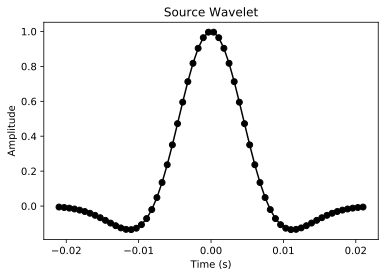

In [6]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, '-ok')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [ ]:
# Full Zoeppritz using tensorflow

def gather(input1,tftheta,tfsrc):
    print('input1:',input1)
    vp = tf.expand_dims(input1[:,:,0],2)
    vs = tf.expand_dims(input1[:,:,1],2)
    rho = tf.expand_dims(input1[:,:,2],2)
    vp=tf.check_numerics(vp,"Nan at vp start")
    vs=tf.check_numerics(vs,"Nan at vp start")
    rho=tf.check_numerics(rho,"Nan at vp start")
    

    nref= tf.shape(input1)[1]#vp.get_shape()[1]#.as_list()[1]
    bs=tf.shape(input1)[0]
    ntheta=tf.shape(tftheta)[1]
    #nt=tf.shape(input1)[1]
    
    tfzero=tf.zeros([bs,1,ntheta], dtype=tf.float32)
    
    tfangle = tf.expand_dims(tf.convert_to_tensor(tftheta, 
                                                  dtype=tf.float32),0)
    tfangle=tf.tile(tfangle,[bs,nref-1,1])

  
    vp1=tf.tile(vp[:,0:nref-1],[1, 1, ntheta])
    vs1=tf.tile(vs[:,0:nref-1],[1, 1, ntheta])
    d1=tf.tile(rho[:,0:nref-1],[1, 1, ntheta])

    vp2=tf.tile(vp[:,1:nref],[1, 1, ntheta])
    vs2=tf.tile(vs[:,1:nref],[1, 1, ntheta])
    d2=tf.tile(rho[:,1:nref],[1, 1, ntheta])
    
    
    vpj1=tf.complex(vp1,tf.zeros_like(vp1))
    vsj1=tf.complex(vs1,tf.zeros_like(vs1))
    dj1=tf.complex(d1,tf.zeros_like(d1))

    vpj2=tf.complex(vp2,tf.zeros_like(vp2))
    vsj2=tf.complex(vs2,tf.zeros_like(vs2))
    dj2=tf.complex(d2,tf.zeros_like(d2))
    
    
    t=tf.scalar_mul(np.pi/180,tfangle)    
    p=tf.divide(tf.sin(t),vp1)
    ct=tf.cos(t)
    
    sint=tf.complex(tf.sin(t),tf.zeros_like(t))
    
    # FULL ZOEPPRITZ
    ct2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vpj2),tf.square(vpj1))))))
    
    cj1=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj1),tf.square(vpj1))))))
    
    cj2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj2),tf.square(vpj1))))))
    
    a=tf.subtract(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p)))))
            )
    
    b=tf.add(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1,tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))
            )
    c=tf.add(
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))),
            tf.multiply(d2,tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))
            )
    
    d=tf.scalar_mul(2.0, 
            tf.subtract(
                    tf.multiply(d2,tf.square(vs2)),
                    tf.multiply(d1,tf.square(vs1)))
            )
            
    E=tf.add(
            tf.multiply(b,tf.divide(ct,vp1)),
            tf.multiply(c,tf.divide(ct2,vp2))
            )
    F=tf.add(
            tf.multiply(b,tf.divide(cj1,vs1)),
            tf.multiply(c,tf.divide(cj2,vs2))
            )
    G=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct,cj2)),
                          tf.multiply(vp1,vs2))
                  )
    H=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct2,cj1)),
                          tf.multiply(vp2,vs1))
                  )
    D=tf.add(
            tf.multiply(E,F),
            tf.multiply(G,tf.multiply(H,tf.square(p)))
            )
    
    Rpp=tf.real(tf.divide(tf.subtract(
            tf.multiply(tf.subtract( tf.multiply(b,tf.divide(ct,vp1)), tf.multiply(c,tf.divide(ct2,vp2))),F),
            tf.multiply( tf.add(a, tf.multiply(d,tf.multiply(ct,tf.divide(cj2,tf.multiply(vp1,vs2))))) ,tf.multiply(H,tf.square(p)))            
            ),D))
    #print('Rpp1:',Rpp)
    Rpp=tf.concat([Rpp,tfzero],1)
    #print('Rpp2:',Rpp)
    # Rpp1=tf.zeros()
    Rpp1=tf.expand_dims(Rpp,axis=3)
    #Rpp1=tf.where(tf.is_nan(Rpp1), tf.zeros_like(Rpp1), Rpp1)
    #print('Rpp11:',Rpp1)
    #print('tfsrc:',tfsrc)
    seis=tf.transpose(tf.nn.conv2d(Rpp1,tfsrc,strides=[1,1,1,1],padding='SAME'),perm=[0,2,1,3])
    #print("seis:",seis)
    seis=tf.reshape(seis,[-1,nt*ntheta])
    #seis=tf.Print(seis,[tf.shape(seis)])

    #print('seis:',seis)
    
    return seis,Rpp

In [7]:
# Convert Vp, Vs and Density logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/(Vp[i,:]*1e3))

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

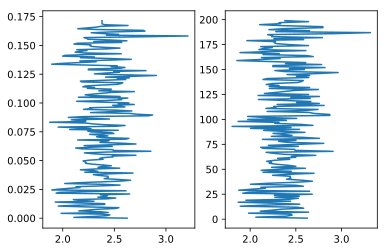

In [8]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


In [ ]:
# Forward modeling results (Seismic gathers)

# Test the forward modeling
bs=Vp_time.shape[0]
input11=np.zeros([bs,nt,3],dtype=np.float32)

input11[0:bs,:,0]=Vp_time[0:bs,:]
input11[0:bs,:,1]=Vs_time[0:bs,:]
input11[0:bs,:,2]=RHOB_time[0:bs,:]
# plt.plot(np.squeeze(input11))
# plt.show()

input111=tf.convert_to_tensor(input11,dtype=tf.float32)
# print("src:",src.shape)


tfsrc=tf.reshape(tf.constant(src,dtype=tf.float32),[src_len,1,1,1])


# print('tfsrc:',tfsrc)
# print('angle:',angle.shape)
tftheta=tf.convert_to_tensor(angle,dtype=tf.float32)
# print('tftheta:',tftheta)
seisgen=gather(input111,tftheta,tfsrc)


sess=tf.Session()
seis11,Rpp11=sess.run(seisgen)

sess.close()

seis=np.transpose(np.reshape(seis11,[-1,ntheta,nt]),[0,2,1])
Rpp=Rpp11#np.reshape(Rpp11,[bs,nt,ntheta])

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

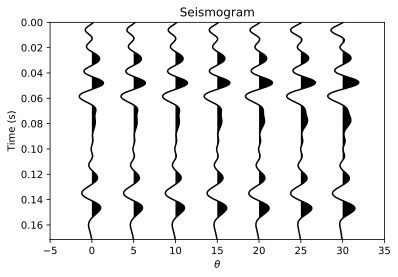

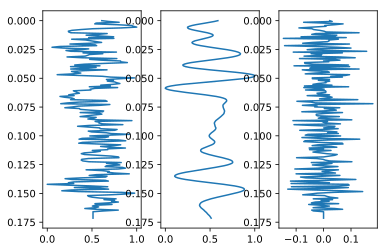

In [9]:
# Load forward modeled seismic data and Rpp
seis = np.load('../../../Data_generation_base_case/seismic_forward_modeled.npy')
Rpp = np.load('../../../Data_generation_base_case/Rpp_forward_modeled.npy')

sample_number = 12
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [10]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model, model_from_json, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils, normalize
from keras.backend import manual_variable_initialization
from keras.callbacks import EarlyStopping, ModelCheckpoint

# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [11]:
# Getting the input data (normalized) and output data 

# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

# Selecting near(0 degree) and far (30 degree) angle traces from the full seismic gathers
row_idx = np.array([0, 6])
angle_seis_reshaped_normalized = seis_reshaped_normalized[:,row_idx,:]

# Concatenate Porosity, Vclay, Sw 
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]

# Normalize porosity
porosity_norm = (porosity - np.min(porosity))/(np.max(porosity) - np.min(porosity))

# petromodel = np.concatenate((porosity_norm,vclay,Sw), axis=1)
# petromodel = petromodel.reshape((num_examples, 3, ndepth))
petromodel = np.concatenate((porosity_norm,vclay), axis=1)
petromodel = petromodel.reshape((num_examples, 2, ndepth))


# Split data into train and test set - petro model
# X_train_petro, X_test_petro, Y_train_petro, Y_test_petro = sklearn.model_selection.train_test_split(seis_reshaped_normalized, 
#                                                                             petromodel, test_size=0.2, random_state=1)
X_train_petro, X_test_petro, Y_train_petro_norm, Y_test_petro_norm = sklearn.model_selection.train_test_split(angle_seis_reshaped_normalized, 
                                                                            petromodel, test_size=0.2, random_state=1)

# Add 4th dimension of number of channels=1 to the input data
X_train_petro = np.expand_dims(X_train_petro, axis=3)
X_test_petro = np.expand_dims(X_test_petro, axis=3)

print ("number of training examples petromodel = " + str(X_train_petro.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples petromodel = " + str(X_test_petro.shape[0]))
print ("X_train_petromodel shape: " + str(X_train_petro.shape))
print ("Y_train_petromodel shape: " + str(Y_train_petro_norm.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test_petromodel shape: " + str(X_test_petro.shape))
print ("Y_test_petromodel shape: " + str(Y_test_petro_norm.shape))

number of training examples petromodel = 2000
number of test examples petromodel = 500
X_train_petromodel shape: (2000, 2, 246, 1)
Y_train_petromodel shape: (2000, 2, 199)
X_test_petromodel shape: (500, 2, 246, 1)
Y_test_petromodel shape: (500, 2, 199)


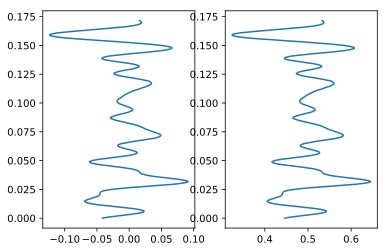

In [12]:
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)

In [13]:
# Building neural network for petrophysical properties prediction in Keras 
given_seed = 3 # For repeatibility


def petronet(input_shape):
    """
    Implementation of the PetroNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (2, 7), strides=(1, 2), name='conv0', padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv0')(X)
    # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool0')(X)
    
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (2, 15), strides=(1, 2), name='conv1',padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv1')(X)
    # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool1')(X)
    
    
#     # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (1, 30), strides=(1, 2), name='conv2',padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn2')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv2')(X)
#     # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool2')(X)
    
    
#     # CONV -> BN -> RELU Block applied to X
    X = Conv2D(8, (1, 60), strides=(1, 2), name='conv3',padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn3')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv3')(X)
#     # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool3')(X)
    

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    
    # Considering Sw first dimension is 3, without first dimension is 2
    X = Dense(199*2, name='fc1', 
             kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = Activation('relu')(X)
#     X = LeakyReLU(0.3)(X)
    X = Reshape((2, 199))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='PetroModel')

    return model
    ### END CODE HERE ###

In [14]:
# Create the model
PetroModel = petronet(X_train_petro.shape[1:])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
# Summary and plot of the model

PetroModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 2, 123, 64)        960       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 2, 123, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 123, 64)        0         
_________________________________________________________________
drop_conv0 (Dropout)         (None, 2, 123, 64)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 62, 32)         61472     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 62, 32)         128       
__________

In [225]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 100.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [16]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


PetroModel.compile(loss='mean_squared_error', optimizer = adam)
# PetroModel.compile(loss='mean_squared_logarithmic_error', optimizer = adam)

In [26]:
# Removing previous best_model.h5 file
import os
os.remove("best_model_new_far.h5")

In [17]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model_new_far.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [18]:
# Start the training
# Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [lrate,es,mc]
# history = PetroModel.fit(X_train_petro, Y_train_petro, 
#                          validation_split=0.2, epochs=500, batch_size=32, callbacks=callbacks_list, 
#                         verbose=0)

history = PetroModel.fit(X_train_petro, Y_train_petro_norm, validation_split=0.2, 
                         epochs=1500, batch_size=32, callbacks=[es, mc],
                        verbose = 0)

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.08249, saving model to best_model_new_far.h5

Epoch 00002: val_loss improved from 0.08249 to 0.07001, saving model to best_model_new_far.h5

Epoch 00003: val_loss improved from 0.07001 to 0.06452, saving model to best_model_new_far.h5

Epoch 00004: val_loss did not improve from 0.06452

Epoch 00005: val_loss improved from 0.06452 to 0.05986, saving model to best_model_new_far.h5

Epoch 00006: val_loss improved from 0.05986 to 0.05630, saving model to best_model_new_far.h5

Epoch 00007: val_loss did not improve from 0.05630

Epoch 00008: val_loss improved from 0.05630 to 0.05275, saving model to best_model_new_far.h5

Epoch 00009: val_loss did not improve from 0.05275

Epoch 00010: val_loss improved from 0.05275 to 0.05075, saving model to best_model_new_far.h5

Epoch 00011: val_loss improved from 0.05075 to 0.04674, saving model to best_model_new_far.h5

Epoch 00012: val_loss did not improve f


Epoch 00132: val_loss did not improve from 0.02910

Epoch 00133: val_loss did not improve from 0.02910

Epoch 00134: val_loss did not improve from 0.02910

Epoch 00135: val_loss did not improve from 0.02910

Epoch 00136: val_loss did not improve from 0.02910

Epoch 00137: val_loss did not improve from 0.02910

Epoch 00138: val_loss did not improve from 0.02910

Epoch 00139: val_loss did not improve from 0.02910

Epoch 00140: val_loss did not improve from 0.02910

Epoch 00141: val_loss did not improve from 0.02910

Epoch 00142: val_loss did not improve from 0.02910

Epoch 00143: val_loss did not improve from 0.02910

Epoch 00144: val_loss did not improve from 0.02910

Epoch 00145: val_loss did not improve from 0.02910

Epoch 00146: val_loss did not improve from 0.02910

Epoch 00147: val_loss did not improve from 0.02910

Epoch 00148: val_loss did not improve from 0.02910

Epoch 00149: val_loss did not improve from 0.02910

Epoch 00150: val_loss did not improve from 0.02910

Epoch 00151


Epoch 00283: val_loss did not improve from 0.02797

Epoch 00284: val_loss did not improve from 0.02797

Epoch 00285: val_loss did not improve from 0.02797

Epoch 00286: val_loss did not improve from 0.02797

Epoch 00287: val_loss did not improve from 0.02797

Epoch 00288: val_loss did not improve from 0.02797

Epoch 00289: val_loss did not improve from 0.02797

Epoch 00290: val_loss did not improve from 0.02797

Epoch 00291: val_loss did not improve from 0.02797

Epoch 00292: val_loss did not improve from 0.02797

Epoch 00293: val_loss did not improve from 0.02797

Epoch 00294: val_loss did not improve from 0.02797

Epoch 00295: val_loss did not improve from 0.02797

Epoch 00296: val_loss did not improve from 0.02797

Epoch 00297: val_loss did not improve from 0.02797

Epoch 00298: val_loss did not improve from 0.02797

Epoch 00299: val_loss did not improve from 0.02797

Epoch 00300: val_loss did not improve from 0.02797

Epoch 00301: val_loss did not improve from 0.02797

Epoch 00302


Epoch 00435: val_loss did not improve from 0.02741

Epoch 00436: val_loss did not improve from 0.02741

Epoch 00437: val_loss did not improve from 0.02741

Epoch 00438: val_loss did not improve from 0.02741

Epoch 00439: val_loss did not improve from 0.02741

Epoch 00440: val_loss did not improve from 0.02741

Epoch 00441: val_loss did not improve from 0.02741

Epoch 00442: val_loss did not improve from 0.02741

Epoch 00443: val_loss did not improve from 0.02741

Epoch 00444: val_loss did not improve from 0.02741

Epoch 00445: val_loss did not improve from 0.02741

Epoch 00446: val_loss did not improve from 0.02741

Epoch 00447: val_loss did not improve from 0.02741

Epoch 00448: val_loss did not improve from 0.02741

Epoch 00449: val_loss did not improve from 0.02741

Epoch 00450: val_loss did not improve from 0.02741

Epoch 00451: val_loss did not improve from 0.02741

Epoch 00452: val_loss did not improve from 0.02741

Epoch 00453: val_loss did not improve from 0.02741

Epoch 00454


Epoch 00591: val_loss did not improve from 0.02734

Epoch 00592: val_loss did not improve from 0.02734

Epoch 00593: val_loss did not improve from 0.02734

Epoch 00594: val_loss did not improve from 0.02734

Epoch 00595: val_loss did not improve from 0.02734

Epoch 00596: val_loss did not improve from 0.02734

Epoch 00597: val_loss did not improve from 0.02734

Epoch 00598: val_loss did not improve from 0.02734

Epoch 00599: val_loss did not improve from 0.02734

Epoch 00600: val_loss did not improve from 0.02734

Epoch 00601: val_loss did not improve from 0.02734

Epoch 00602: val_loss did not improve from 0.02734

Epoch 00603: val_loss did not improve from 0.02734

Epoch 00604: val_loss did not improve from 0.02734

Epoch 00605: val_loss did not improve from 0.02734

Epoch 00606: val_loss did not improve from 0.02734

Epoch 00607: val_loss did not improve from 0.02734

Epoch 00608: val_loss did not improve from 0.02734

Epoch 00609: val_loss did not improve from 0.02734

Epoch 00610

In [19]:
# load the saved model
PetroModel = load_model('best_model_new_far.h5')

In [20]:
# Testing and evaluating the model
preds = PetroModel.evaluate(X_test_petro, Y_test_petro_norm, batch_size=32, verbose=0, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))


Loss = 0.027303213596343995


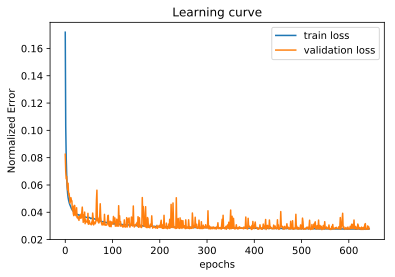

In [21]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['loss']/np.max(history.history['loss']))
# plt.plot(history.history['val_loss']/np.max(history.history['val_loss']))
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Normalized Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='upper right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [32]:
# Save trained model 
# serialize model to JSON

# manual_variable_initialization(True)
model_json = PetroModel.to_json()
with open("petro_model_16Jul2019.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
PetroModel.save_weights("PetroModel_16Jul2019.h5")
print("Saved model to disk")


Saved model to disk


In [33]:
# Load saved model

####### Saved model does not work ######

# load json and create model
json_file = open('petro_model_16Jul2019.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("PetroModel_16Jul2019.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

PetroModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

Loaded model from disk


In [22]:
# Predict training and test data using the trained network
test_output_petro_norm = PetroModel.predict(X_test_petro)
train_output_petro_norm = PetroModel.predict(X_train_petro)

# Initialization
train_output_petro = np.zeros(train_output_petro_norm.shape)
test_output_petro = np.zeros(test_output_petro_norm.shape)
Y_train_petro = np.zeros(Y_train_petro_norm.shape)
Y_test_petro = np.zeros(Y_test_petro_norm.shape)

# Back transforming porosity to unnormalized values 
train_output_petro[:,0,:] = train_output_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
test_output_petro[:,0,:] = test_output_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

train_output_petro[:,1,:] = train_output_petro_norm[:,1,:]
test_output_petro[:,1,:] = test_output_petro_norm[:,1,:]

Y_train_petro[:,0,:] = Y_train_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
Y_test_petro[:,0,:] = Y_test_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_train_petro[:,1,:] = Y_train_petro_norm[:,1,:]
Y_test_petro[:,1,:] = Y_test_petro_norm[:,1,:]

In [29]:
# RMSE with respect to mean 
rmse_train = np.sqrt(np.mean(((train_output_petro - Y_train_petro)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_train_petro, axis = 0), axis=1)
rmse_test = np.sqrt(np.mean(((test_output_petro - Y_test_petro)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_test_petro, axis = 0), axis=1)

print("Training error = ", rmse_train)
print("Test error = ", rmse_test)

Training error =  [0.17052618 0.30260018]
Test error =  [0.19341821 0.3788528 ]


(0, 1)

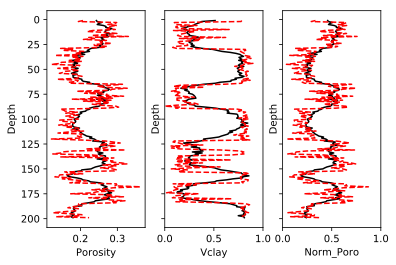

In [23]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(train_output_petro[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_train_petro[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(0.05,0.4)

axarr[1].plot(train_output_petro[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_train_petro[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

# axarr[2].plot(train_output_petro[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_train_petro[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(0,1)

axarr[2].plot(train_output_petro_norm[sample_number, 0, :], depth, '-k')
axarr[2].plot(Y_train_petro_norm[sample_number, 0, :], depth, '--r')
axarr[2].set_xlabel("Norm_Poro")
axarr[2].set_ylabel("Depth")
axarr[2].invert_yaxis()
axarr[2].set_xlim(0,1)

(0, 1)

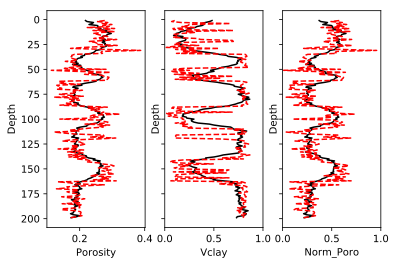

In [24]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(test_output_petro[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_test_petro[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output_petro[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_test_petro[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

# axarr[2].plot(test_output_petro[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_test_petro[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(0,1)

axarr[2].plot(test_output_petro_norm[sample_number, 0, :], depth, '-k')
axarr[2].plot(Y_test_petro_norm[sample_number, 0, :], depth, '--r')
axarr[2].set_xlabel("Norm_Poro")
axarr[2].set_ylabel("Depth")
axarr[2].invert_yaxis()
axarr[2].set_xlim(0,1)

In [25]:
# Correlation coefficient between true and predicted traces 

Porosity_corr_train = np.zeros(train_output_petro.shape[0])
Vclay_corr_train = np.zeros(train_output_petro.shape[0])
# Sw_corr_train = np.zeros(train_output_petro.shape[0])
for i in range(train_output_petro.shape[0]):
    Porosity_corr_train[i] = np.corrcoef(train_output_petro[i,0,:], Y_train_petro[i,0,:])[0,1]
    Vclay_corr_train[i] = np.corrcoef(train_output_petro[i,1,:], Y_train_petro[i,1,:])[0,1]
#     Sw_corr_train[i] = np.corrcoef(train_output_petro[i,2,:], Y_train_petro[i,2,:])[0,1]
    
Porosity_corr_test = np.zeros(test_output_petro.shape[0])
Vclay_corr_test = np.zeros(test_output_petro.shape[0])
Sw_corr_test = np.zeros(test_output_petro.shape[0])
for i in range(test_output_petro.shape[0]):
    Porosity_corr_test[i] = np.corrcoef(test_output_petro[i,0,:], Y_test_petro[i,0,:])[0,1]
    Vclay_corr_test[i] = np.corrcoef(test_output_petro[i,1,:], Y_test_petro[i,1,:])[0,1]
#     Sw_corr_test[i] = np.corrcoef(test_output_petro[i,2,:], Y_test_petro[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_train))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_train))
# print("Average correlation in Sw for training data = ", np.mean(Sw_corr_train))

print("Average correlation in porosity for test data = ", np.mean(Porosity_corr_test))
print("Average correlation in Vclay for test data = ", np.mean(Vclay_corr_test))
# print("Average correlation in Sw for test data = ", np.mean(Sw_corr_test))


Average correlation in porosity for training data =  0.6920286716589694
Average correlation in Vclay for training data =  0.8091705561741454
Average correlation in porosity for test data =  0.6430358031841635
Average correlation in Vclay for test data =  0.7662924275556229


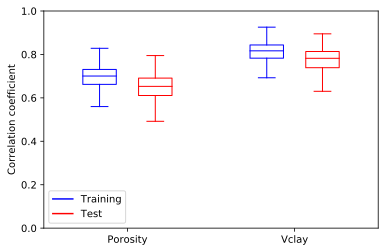

In [26]:
# Box plot of correlation coefficients 

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
#     setp(bp['fliers'][0], color='blue')
#     setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
#     setp(bp['fliers'][2], color='red')
#     setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

# Some fake data to plot
A= [Porosity_corr_train, Porosity_corr_test]
B = [Vclay_corr_train, Vclay_corr_test]
# C = [Sw_corr_train, Sw_corr_test]

fig = figure()
ax = axes()

# first boxplot pair
bp = boxplot(A, positions = [1, 2], widths = 0.6, showfliers=False)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(B, positions = [4, 5], widths = 0.6, showfliers=False)
setBoxColors(bp)

# thrid boxplot pair
# bp = boxplot(C, positions = [7, 8], widths = 0.6, showfliers=False)
# setBoxColors(bp)

# set axes limits and labels
# xlim(0,9)
xlim(0,6)
ylim(0,1)
# ax.set_xticklabels(['Porosity', 'Vclay', 'Sw'])
ax.set_xticklabels(['Porosity', 'Vclay'])
# ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticks([1.5, 4.5])
plt.ylabel('Correlation coefficient')

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Training', 'Test'), loc='lower left')
hB.set_visible(False)
hR.set_visible(False)

In [ ]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,0,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.title('Training examples')



In [ ]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,1,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,1,:], histtype='step', color='red')
    plt.xlabel('Vclay')
    plt.ylabel('Frequency')
    plt.title('Training examples')

In [ ]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,2,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,2,:], histtype='step', color='red')
    plt.xlabel('Sw')
    plt.ylabel('Frequency')
    plt.title('Training examples')

In [ ]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,0,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.title('Test examples')

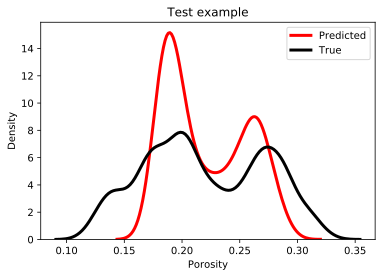

In [27]:
# Density estimate for true vs predicted (test example) Porosity

import seaborn as sns

sample_number = 12
sns.kdeplot(test_output_petro[sample_number,0,:],  
             color='red', label='Predicted', linewidth=3,
            bw=0.01,
             clip=(np.min(test_output_petro[sample_number,0,:]), np.max(test_output_petro[sample_number,0,:])))
sns.kdeplot(Y_test_petro[sample_number,0,:],  
             color='black', label='True', linewidth=3,
            bw=0.01,
             clip=(np.min(Y_test_petro[sample_number,0,:]), np.max(Y_test_petro[sample_number,0,:])))
plt.xlabel('Porosity')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()

(-0.1, 1.1)

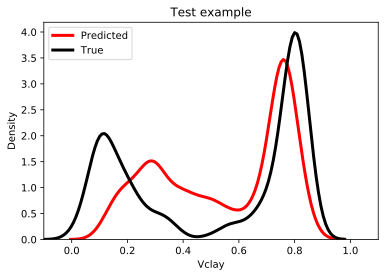

In [28]:
# Density estimate for true vs predicted (test example) Vclay

sample_number = 12

sns.kdeplot(test_output_petro[sample_number,1,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output_petro[sample_number,1,:]), np.max(test_output_petro[sample_number,1,:])))
sns.kdeplot(Y_test_petro[sample_number,1,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test_petro[sample_number,1,:]), np.max(Y_test_petro[sample_number,1,:])))
plt.xlabel('Vclay')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

In [ ]:
# Density estimate for true vs predicted (test example) Water saturation 

sample_number = 12

sns.kdeplot(test_output_petro[sample_number,2,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output_petro[sample_number,2,:]), np.max(test_output_petro[sample_number,2,:])))
sns.kdeplot(Y_test_petro[sample_number,2,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test_petro[sample_number,2,:]), np.max(Y_test_petro[sample_number,2,:])))
plt.xlabel('Sw')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

In [ ]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,1,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,1,:], histtype='step', color='red')
    plt.xlabel('Vclay')
    plt.ylabel('Frequency')
    plt.title('Test examples')

In [ ]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,2,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,2,:], histtype='step', color='red')
    plt.xlabel('Sw')
    plt.ylabel('Frequency')
    plt.title('Test examples')

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,2,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Sw)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,2,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.0012934497175326732,
  'len_scale': 21.23972428553214,
  'nugget': 2.423482266301845e-38},
 array([[ 1.76310878e-08, -1.49527936e-04, -1.62472268e-08],
        [-1.49527936e-04,  7.51454224e+00,  1.99659600e-04],
        [-1.62472268e-08,  1.99659600e-04,  1.66934746e-08]]))

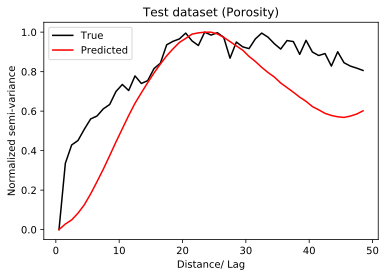

In [29]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.05575099290761263,
  'len_scale': 21.903715073577796,
  'nugget': 1.5727464628216449e-34},
 array([[ 3.28844016e-05, -6.56322911e-03, -3.01769368e-05],
        [-6.56322911e-03,  8.08105072e+00,  8.91468225e-03],
        [-3.01769368e-05,  8.91468225e-03,  3.10537896e-05]]))

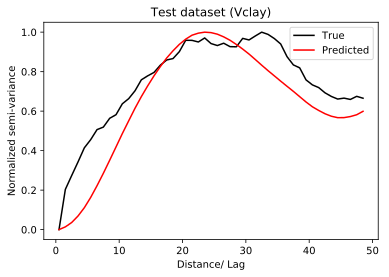

In [30]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Sw)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Spectral coherence between true and predicted 

sample_number = 25
plt.cohere(Y_train_petro[sample_number,0,:], train_output_petro[sample_number,0,:], NFFT=16, Fs=1, color="blue")
plt.cohere(Y_train_petro[sample_number,1,:], train_output_petro[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# plt.cohere(Y_train_petro[sample_number,2,:], train_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")


# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

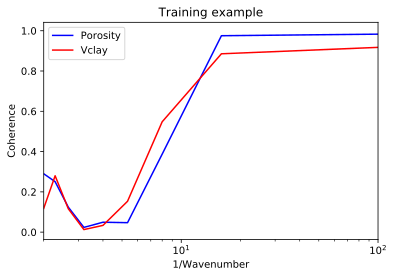

In [31]:
# Spectral coherence between true and predicted (training data)

sample_number = 25
Cxy_poro, wavenumber_poro = plt.cohere(Y_train_petro[sample_number,0,:], train_output_petro[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_train_petro[sample_number,1,:], train_output_petro[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue")
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red")
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

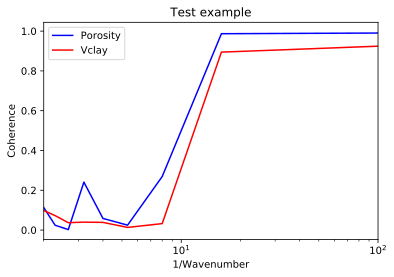

In [32]:
# Spectral coherence between true and predicted (test data)

sample_number = 12
Cxy_poro, wavenumber_poro = plt.cohere(Y_test_petro[sample_number,0,:], test_output_petro[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_test_petro[sample_number,1,:], test_output_petro[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue")
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red")
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)

Text(0,0.5,'Depth')

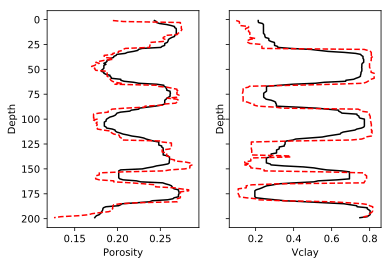

In [33]:
import scipy.signal as sp


# Checking training data (smoothed)

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True)

ker_width = 15

axarr[0].plot(sp.medfilt(train_output_petro[sample_number, 0, :],ker_width), depth, '-k')
axarr[0].plot(sp.medfilt(Y_train_petro[sample_number, 0, :], ker_width), depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(sp.medfilt(train_output_petro[sample_number, 1, :], ker_width), depth, '-k')
axarr[1].plot(sp.medfilt(Y_train_petro[sample_number, 1, :],ker_width), depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
# axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

In [34]:
por_corr_coeff_smooth_train = np.corrcoef(sp.medfilt(train_output_petro[sample_number, 0, :],ker_width),
                                                     sp.medfilt(Y_train_petro[sample_number, 0, :], ker_width))
                                          
vclay_corr_coeff_smooth_train = np.corrcoef(sp.medfilt(train_output_petro[sample_number, 1, :],ker_width),
                                                     sp.medfilt(Y_train_petro[sample_number, 1, :], ker_width))

print("Correlation coefficient between smoothed true and predicted porosity for training example = ", 
     '%.3f'%(por_corr_coeff_smooth_train[0,1]))
print("Correlation coefficient between smoothed true and predicted vclay for training example = ", 
     '%.3f'%(vclay_corr_coeff_smooth_train[0,1]))

Correlation coefficient between smoothed true and predicted porosity for training example =  0.912
Correlation coefficient between smoothed true and predicted vclay for training example =  0.935


Text(0,0.5,'Depth')

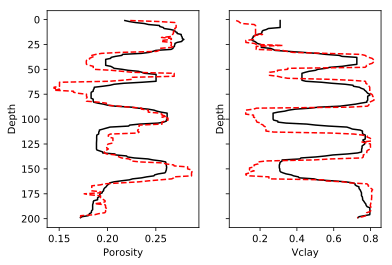

In [35]:
# Checking testing data (smoothed)

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True)

ker_width = 15

axarr[0].plot(sp.medfilt(test_output_petro[sample_number, 0, :],ker_width), depth, '-k')
axarr[0].plot(sp.medfilt(Y_test_petro[sample_number, 0, :], ker_width), depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(sp.medfilt(test_output_petro[sample_number, 1, :],ker_width), depth, '-k')
axarr[1].plot(sp.medfilt(Y_test_petro[sample_number, 1, :],ker_width), depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
# axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

In [36]:
por_corr_coeff_smooth_test = np.corrcoef(sp.medfilt(test_output_petro[sample_number, 0, :],ker_width),
                                                     sp.medfilt(Y_test_petro[sample_number, 0, :], ker_width))
                                          
vclay_corr_coeff_smooth_test = np.corrcoef(sp.medfilt(test_output_petro[sample_number, 1, :],ker_width),
                                                     sp.medfilt(Y_test_petro[sample_number, 1, :], ker_width))

print("Correlation coefficient between smoothed true and predicted porosity for test example = ", 
     '%.3f'%(por_corr_coeff_smooth_test[0,1]))
print("Correlation coefficient between smoothed true and predicted vclay for test example = ", 
     '%.3f'%(vclay_corr_coeff_smooth_test[0,1]))

Correlation coefficient between smoothed true and predicted porosity for test example =  0.832
Correlation coefficient between smoothed true and predicted vclay for test example =  0.884
